# Wyscout Data for Inter 2017-18

In questo notebook viene effettuata un'analisi dei passaggi dei calciatori dell'Inter durante la stagione 2017-2018. <br>
In particolare: <br>
1) conteggio dei passaggi per ogni calciatore in ogni match <br>
2) evoluzione del conteggio dei passaggi di Brozovic durante la stagione (confronto con Borja Valero) <br>
3) conteggio dei passaggi accurati e calcolo della percentuale per ogni calciatore in ogni match <br>
4) evoluzione della percentuale di accuratezza dei passaggi di Brozovic durante la stagione (confronto con Borja Valero) <br>
5) conteggio dei passaggi in avanti e calcolo della percentuale per ogni calciatore in ogni match <br>
6) evoluzione della percentuale di passaggi in avanti di Brozovic durante la stagione (confronto con Borja Valero) <br>
7) rank dei calciatori in base al numero totale di passaggi effettuati durante la stagione <br>
8) rank dei calciatori in base alla percentuale di passaggi accurati durante la stagione <br>
9) rank dei calciatori in base alla percentuale di passaggi in avanti durante la stagione <br>

## utilities

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import util
path = "C:/Users/Mauro/OneDrive/Documenti/Football/Inter_2017_2018"
inter_id = 3161

**COUNT TOTAL PASSES FOR EACH PLAYER IN EACH MATCH**

In [17]:
inter_matches_events = pd.read_csv(os.path.join(path, "inter_matches_events.csv"))
#filter by pass event (eventId == 8) and team associated to the event (teamId == 3161, which is inter_id)
#get column referred to match (matchId) and player (playerId)
total_passes = inter_matches_events.query("eventId == 8 and teamId == 3161")[['matchId', 'playerId']]
total_passes.head(3)

,matchId,playerId
5,2575963,20517
15,2575963,116349
16,2575963,20556


In [18]:
#group the passes by playerId and matchId to obtain the count of passes for each player in each match
total_passes = pd.DataFrame(total_passes.groupby(['playerId', 'matchId']).size()).reset_index()
total_passes.columns = ["playerId", "matchId", "#passes"]
total_passes.head(3)

,playerId,matchId,#passes
0,3344,2576174,1
1,3344,2576180,27
2,3344,2576191,26


In [19]:
#merge the count of passes with players data to obtain the players' name and the players' role
inter_players = pd.read_csv(os.path.join(path, "inter_players.csv"))
total_passes = pd.merge(total_passes, inter_players, how="left", left_on="playerId", right_on="wyId")[["playerId", "role_name", "shortName", "matchId", "#passes"]]
total_passes.head(3)

,playerId,role_name,shortName,matchId,#passes
0,3344,Midfielder,Rafinha,2576174,1
1,3344,Midfielder,Rafinha,2576180,27
2,3344,Midfielder,Rafinha,2576191,26


In [20]:
#merge the count of passes with matches data to obtain the matches' gameweek and the matches' label
inter_matches = pd.read_csv(os.path.join(path, "inter_matches.csv"))
total_passes = pd.merge(total_passes, inter_matches, how="left", left_on="matchId", right_on="wyId")[["playerId", "role_name", "shortName", "matchId", "gameweek", "label", "#passes"]]
total_passes.head(3)

,playerId,role_name,shortName,matchId,gameweek,label,#passes
0,3344,Midfielder,Rafinha,2576174,22,"SPAL - Internazionale, 1 - 1",1
1,3344,Midfielder,Rafinha,2576180,23,"Internazionale - Crotone, 1 - 1",27
2,3344,Midfielder,Rafinha,2576191,24,"Internazionale - Bologna, 2 - 1",26


**FOCUS ON BROZOVIC PASS PERFORMANCE**

In [21]:
brozovic = inter_players[inter_players.shortName.str.contains("Brozo")]
brozovic

,wyId,role_name,shortName
21,69968,Midfielder,M. Brozović


In [22]:
match_id = inter_matches[inter_matches.label.str.contains(" - Napoli")].wyId.iloc[0]
total_passes.query("playerId == " + str(brozovic.wyId.iloc[0]) + " and matchId == " + str(match_id))

,playerId,role_name,shortName,matchId,gameweek,label,#passes
311,69968,Midfielder,M. Brozović,2576234,28,"Internazionale - Napoli, 0 - 0",57


**BROZOVIC NUMBER OF PASS EVOLUTION DURING THE SEASON (COMPARED WITH BORJA VALERO)**

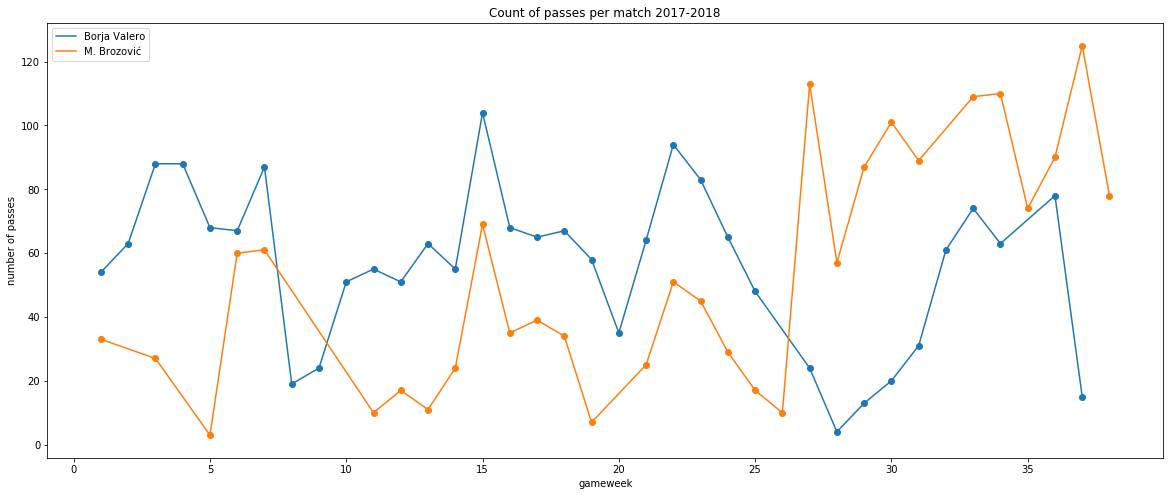

In [23]:
plt.figure(figsize=(20, 8))
players_to_compare = ["M. Brozović", "Borja Valero"]
group = total_passes.query("shortName in " + str(players_to_compare))
for p in group.shortName.unique():
    df = group[group.shortName == p].sort_values(by="gameweek")
    df = df.reset_index(drop=True)
    plt.plot(df.gameweek, df["#passes"])
    plt.scatter(df.gameweek, df["#passes"])
plt.title("Count of passes per match 2017-2018")
plt.xlabel("gameweek")
plt.ylabel("number of passes")
plt.legend(group.shortName.unique())
plt.show()

In [24]:
df.query("gameweek in [25, 26]")[["gameweek", "label"]]

,gameweek,label
18,25,"Genoa - Internazionale, 2 - 0"
19,26,"Internazionale - Benevento, 2 - 0"


Dal grafico in figura si notano chiaramente due diversi intervalli di tempo della stagione: <br> 
- dall'inizio alla giornata 25 (**Genoa-Inter 2-0**), in cui il ruolo di **play-maker** è stato affidato a **Borja Valero** <br>
- dalla giornata 26 (**Inter-Benevento 2-0**) alla fine, in cui il ruolo di **play-maker** è stato affidato a **Brozovic**, che fino ad allora giocava in posizione più avanzata senza avere titolarità fissa <br> 

Si nota come il coinvolgimento nel gioco di **Borja Valero** è sistematicamente più alto rispetto a quello di **Brozovic** fino alla giornata 25. <br> <br>
Dalla giornata 26 in poi, invece, il coinvolgimento nel gioco di **Brozovic**, non solo è sistematicamente più alto rispetto a quello di **Borja Valero**, avendo preso il suo posto in campo, ma è anche più alto e costante rispetto a quello che aveva lo spagnolo nel periodo in cui era lui il titolare in quel ruolo.

**CALCULATE PASS ACCURACY FOR EACH PLAYER IN EACH MATCH**

In [28]:
##filter by pass event (eventId == 8) and team associated to the event (teamId == 3161, which is inter_id)
#filter by accurate == "yes" for each pass (which has 1801 in tags)
positive_passes = inter_matches_events.query("eventId == 8 and teamId == 3161 and accurate == 'yes'")
#get columns referred to match (matchId), player (playerId) and accuarate
positive_passes = positive_passes[['matchId', 'playerId', 'accurate']]
positive_passes.head(3)

,matchId,playerId,accurate
5,2575963,20517,yes
15,2575963,116349,yes
16,2575963,20556,yes


In [29]:
#group accurated pass by match and player to obtain the count of accurated pass for each player in each match
positive_passes = pd.DataFrame(positive_passes.groupby(['playerId', 'matchId', 'accurate']).size()).reset_index()
positive_passes.drop("accurate", axis=1, inplace=True)
positive_passes.columns = ["playerId", "matchId", "#positive_passes"]
positive_passes.head(3)

,playerId,matchId,#positive_passes
0,3344,2576174,1
1,3344,2576180,26
2,3344,2576191,23


In [30]:
#merge with players' data to obtain players' name and players' role
positive_passes = pd.merge(positive_passes, inter_players, how="left", left_on="playerId", right_on="wyId")[["playerId", "role_name", "shortName", "matchId", "#positive_passes"]]
positive_passes.head(3)

,playerId,role_name,shortName,matchId,#positive_passes
0,3344,Midfielder,Rafinha,2576174,1
1,3344,Midfielder,Rafinha,2576180,26
2,3344,Midfielder,Rafinha,2576191,23


In [31]:
#merge with matches' data to obtain matches' gameweek and matches' label
positive_passes = pd.merge(positive_passes, inter_matches, how="left", left_on="matchId", right_on="wyId")[["playerId", "role_name", "shortName", "matchId", "gameweek", "label", "#positive_passes"]]
positive_passes.head(3)

,playerId,role_name,shortName,matchId,gameweek,label,#positive_passes
0,3344,Midfielder,Rafinha,2576174,22,"SPAL - Internazionale, 1 - 1",1
1,3344,Midfielder,Rafinha,2576180,23,"Internazionale - Crotone, 1 - 1",26
2,3344,Midfielder,Rafinha,2576191,24,"Internazionale - Bologna, 2 - 1",23


In [32]:
#merge with count of total passes data 
positive_passes = pd.merge(total_passes, positive_passes, how="left", left_on=["matchId", "playerId"], right_on=["matchId", "playerId"])[["playerId", "role_name_x", "shortName_x", "matchId", "gameweek_x", "label_x", "#positive_passes", "#passes"]]
positive_passes.head(3)

,playerId,role_name_x,shortName_x,matchId,gameweek_x,label_x,#positive_passes,#passes
0,3344,Midfielder,Rafinha,2576174,22,"SPAL - Internazionale, 1 - 1",1.0,1
1,3344,Midfielder,Rafinha,2576180,23,"Internazionale - Crotone, 1 - 1",26.0,27
2,3344,Midfielder,Rafinha,2576191,24,"Internazionale - Bologna, 2 - 1",23.0,26


In [33]:
#calculate pass accuracy dividing count of accurated passes by count of total passes
positive_passes['pass_accuracy'] = round((positive_passes["#positive_passes"] / positive_passes["#passes"]) * 100, 2)
positive_passes.head(3)

,playerId,role_name_x,shortName_x,matchId,gameweek_x,label_x,#positive_passes,#passes,pass_accuracy
0,3344,Midfielder,Rafinha,2576174,22,"SPAL - Internazionale, 1 - 1",1.0,1,100.00
1,3344,Midfielder,Rafinha,2576180,23,"Internazionale - Crotone, 1 - 1",26.0,27,96.30
2,3344,Midfielder,Rafinha,2576191,24,"Internazionale - Bologna, 2 - 1",23.0,26,88.46


**FOCUS ON BROZOVIC PASS PERFORMANCE**

In [34]:
match_id = inter_matches[inter_matches.label.str.contains(" - Napoli")].wyId.iloc[0]
positive_passes.query("playerId == " + str(brozovic.wyId.iloc[0]) + " and matchId == " + str(match_id))

,playerId,role_name_x,shortName_x,matchId,gameweek_x,label_x,#positive_passes,#passes,pass_accuracy
311,69968,Midfielder,M. Brozović,2576234,28,"Internazionale - Napoli, 0 - 0",50.0,57,87.72


**BROZOVIC PASS ACCURACY EVOLUTION DURING THE SEASON (COMPARED WITH BORJA VALERO)**

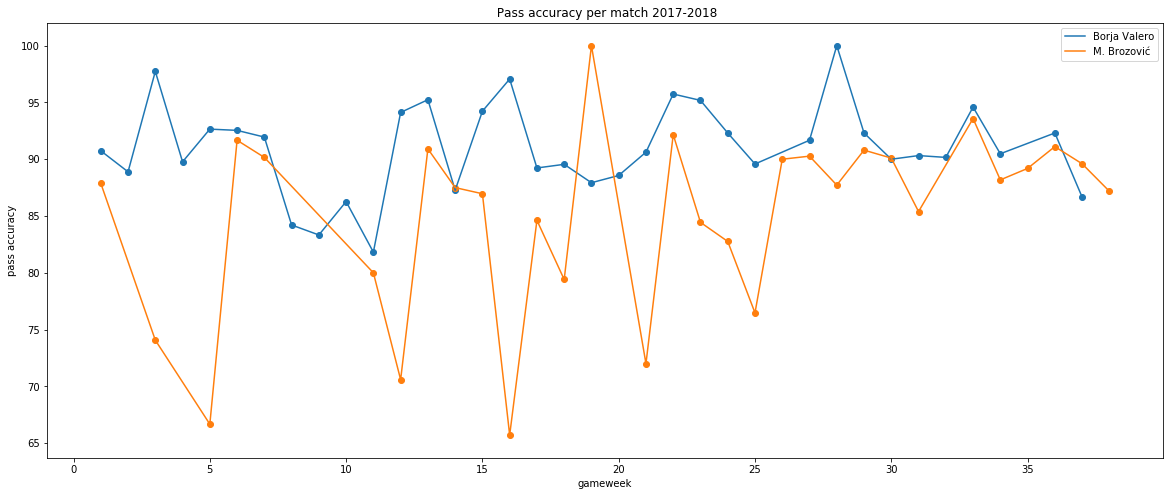

In [35]:
plt.figure(figsize=(20, 8))
players_to_compare = ["M. Brozović", "Borja Valero",]
group = positive_passes.query("shortName_x in " + str(players_to_compare))
for p in group.shortName_x.unique():
    df = group[group.shortName_x == p].sort_values(by="gameweek_x", ascending=True)
    df = df.reset_index(drop=True)
    plt.plot(df.gameweek_x, df["pass_accuracy"])
    plt.scatter(df.gameweek_x, df["pass_accuracy"])
plt.title(" Pass accuracy per match 2017-2018")
plt.xlabel("gameweek")
plt.ylabel("pass accuracy")
plt.legend(group.shortName_x.unique())
plt.show()

Dal grafico in figura si notano chiaramente le seguenti cose: <br>

- l'accuratezza dei passaggi di **Borja Valero** si è mantenuta grossomodo costante durante tutta la stagione <br> <br>
- l'accuratezza dei passaggi di **Brozovic** è molto altalenante e inferiore a quella di **Borja Valero** dall'inizio della stagione alla giornata 25, mentre dalla giornata 26 (**Inter-Benevento 2-0**, in cui inizia a giocare da **play-maker**) si mantiene grossomodo costante (intorno al 90%) in linea con quella di **Borja Valero** (ma dall'analisi dei passaggi totali sappiamo che **Brozovic** è molto più coinvolto nel gioco) 

**CALCULATE FORWARD PASS PERCENTAGE FOR EACH PLAYER IN EACH MATCH**

In [85]:
##filter by pass event (eventId == 8) and team associated to the event (teamId == 3161, which is inter_id)
forward_passes = inter_matches_events.query("eventId == 8 and teamId == 3161")
#assign a label forward="yes" for each forward pass (x_end > x_start)
forward = []
for i in range(len(forward_passes)):
    pass_ = forward_passes.iloc[i]
    if pass_.x_end > pass_.x_start:
        forward.append("yes")
    else:
        forward.append("no")
forward_passes = forward_passes.reset_index(drop=True)
forward_passes['forward'] = pd.Series(forward)
forward_passes.head(3)

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,subEventId,subEventName,teamId,x_start,y_start,x_end,y_end,tags,forward
0,8,Pass,9.514033,180458787,2575963,1H,20517,83.0,High pass,3161,13,6,41.0,15.0,[1801],yes
1,8,Pass,20.302244,180458791,2575963,1H,116349,85.0,Simple pass,3161,38,57,42.0,77.0,"[1401, 1801]",yes
2,8,Pass,22.047245,180458792,2575963,1H,20556,85.0,Simple pass,3161,42,77,30.0,94.0,[1801],no


In [86]:
#get columns referred to match (matchId), player (playerId) and label of the eventual forward pass
forward_passes = forward_passes[["matchId", "playerId", "forward"]]
forward_passes.head(3)

,matchId,playerId,forward
0,2575963,20517,yes
1,2575963,116349,yes
2,2575963,20556,no


In [87]:
#filter to keep only forward pass
forward_passes = forward_passes.query("forward == 'yes'")
#group accurated pass by match and player to obtain the count of forward pass for each player in each match
forward_passes = pd.DataFrame(forward_passes.groupby(['playerId', 'matchId', 'forward']).size()).reset_index()
forward_passes.drop("forward", axis=1, inplace=True)
forward_passes.columns = ["playerId", "matchId", "#forward_passes"]
forward_passes.head(3)

,playerId,matchId,#forward_passes
0,3344,2576180,12
1,3344,2576191,14
2,3344,2576203,28


In [88]:
#merge with players' data to obtain players' name and players' role
forward_passes = pd.merge(forward_passes, inter_players, how="left", left_on="playerId", right_on="wyId")[["playerId", "role_name", "shortName", "matchId", "#forward_passes"]]
forward_passes.head(3)

,playerId,role_name,shortName,matchId,#forward_passes
0,3344,Midfielder,Rafinha,2576180,12
1,3344,Midfielder,Rafinha,2576191,14
2,3344,Midfielder,Rafinha,2576203,28


In [89]:
#merge with matches' data to obtain matches' gameweek and matches' label
forward_passes = pd.merge(forward_passes, inter_matches, how="left", left_on="matchId", right_on="wyId")[["playerId", "role_name", "shortName", "matchId", "gameweek", "label", "#forward_passes"]]
forward_passes.head(3)

,playerId,role_name,shortName,matchId,gameweek,label,#forward_passes
0,3344,Midfielder,Rafinha,2576180,23,"Internazionale - Crotone, 1 - 1",12
1,3344,Midfielder,Rafinha,2576191,24,"Internazionale - Bologna, 2 - 1",14
2,3344,Midfielder,Rafinha,2576203,25,"Genoa - Internazionale, 2 - 0",28


In [90]:
#merge with count of total passes data 
forward_passes = pd.merge(forward_passes, positive_passes, how="left", left_on=["matchId", "playerId"], right_on=["matchId", "playerId"])[["playerId", "role_name_x", "shortName_x", "matchId", "gameweek_x", "label_x", "#forward_passes", "#passes"]]
forward_passes.head(3)

,playerId,role_name_x,shortName_x,matchId,gameweek_x,label_x,#forward_passes,#passes
0,3344,Midfielder,Rafinha,2576180,23,"Internazionale - Crotone, 1 - 1",12,27
1,3344,Midfielder,Rafinha,2576191,24,"Internazionale - Bologna, 2 - 1",14,26
2,3344,Midfielder,Rafinha,2576203,25,"Genoa - Internazionale, 2 - 0",28,41


In [91]:
#calculate forward pass percentage dividing count of forward passes by count of total passes
forward_passes['forward_percentage'] = round((forward_passes["#forward_passes"] / forward_passes["#passes"]) * 100, 2)
forward_passes.head(3)

,playerId,role_name_x,shortName_x,matchId,gameweek_x,label_x,#forward_passes,#passes,forward_percentage
0,3344,Midfielder,Rafinha,2576180,23,"Internazionale - Crotone, 1 - 1",12,27,44.44
1,3344,Midfielder,Rafinha,2576191,24,"Internazionale - Bologna, 2 - 1",14,26,53.85
2,3344,Midfielder,Rafinha,2576203,25,"Genoa - Internazionale, 2 - 0",28,41,68.29


**FOCUS ON BROZOVIC PASS PERFORMANCE**

In [92]:
match_id = inter_matches[inter_matches.label.str.contains(" - Napoli")].wyId.iloc[0]
forward_passes.query("playerId == " + str(brozovic.wyId.iloc[0]) + " and matchId == " + str(match_id))

,playerId,role_name_x,shortName_x,matchId,gameweek_x,label_x,#forward_passes,#passes,forward_percentage
306,69968,Midfielder,M. Brozović,2576234,28,"Internazionale - Napoli, 0 - 0",30,57,52.63


**BROZOVIC FORWARD PASS PERCENTAGE EVOLUTION DURING THE SEASON (COMPARED WITH BORJA VALERO)**

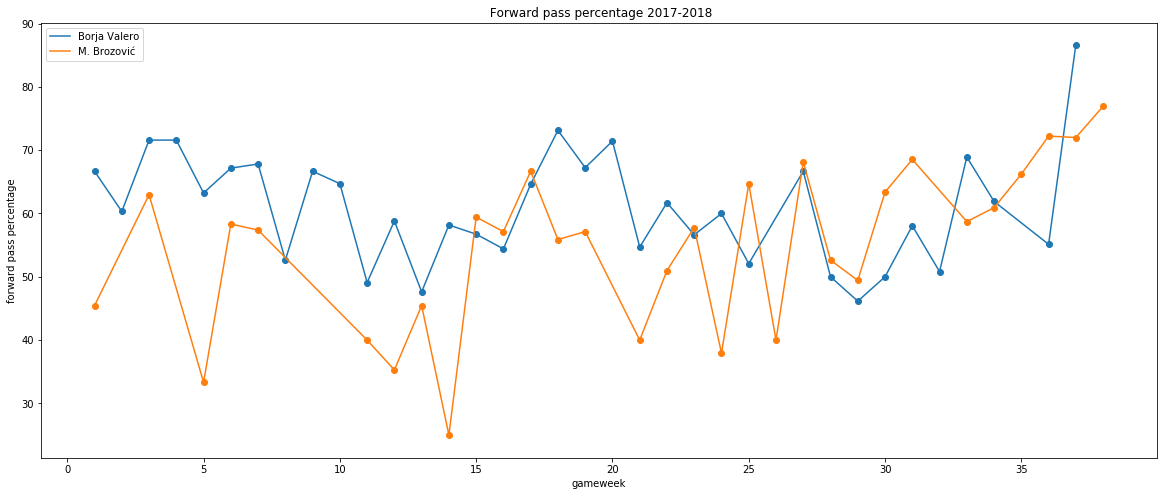

In [93]:
plt.figure(figsize=(20, 8))
players_to_compare = ["M. Brozović", "Borja Valero",]
group = forward_passes.query("shortName_x in " + str(players_to_compare))
for p in group.shortName_x.unique():
    df = group[group.shortName_x == p].sort_values(by="gameweek_x", ascending=True)
    df = df.reset_index(drop=True)
    plt.plot(df.gameweek_x, df["forward_percentage"])
    plt.scatter(df.gameweek_x, df["forward_percentage"])
plt.title(" Forward pass percentage 2017-2018")
plt.xlabel("gameweek")
plt.ylabel("forward pass percentage")
plt.legend(group.shortName_x.unique())
plt.show()

Dal grafico in figura si nota che l'attitudine di **Brozovic** a fare passaggi in avanti, cioè che consentono alla squadra di guadagnare campo, è altalenante fino alla giornata 25, mentre dalla giornata 26 (**Inter-Benevento 2-0**, in cui inizia a giocare da **play-maker**) inizia a crescere di partita in partita raggiungendo i picchi proprio nelle ultime partite della stagione (giornata 38 **Lazio-Inter 2-3: ritorno in UCL** --> massima percentuale di passaggi in avanti di **Brozovic**)

**CONCLUSIONI**: <br> <br>
dal momento in cui **Spalletti** cambia ruolo a **Brozovic** arretrandolo a **play-maker** (giornata 26 **Inter-Benevento 2-0**): <br> <br>
1) **Brozovic** risulta più coinvolto nel gioco e in maniera più costante rispetto a quanto lo era **Borja Valero** in quella posizione <br> <br>
2) **Brozovic** aumenta e stabilizza l'accuratezza dei passaggi <br> <br>
3) **Brozovic** aumenta gradualmente l'attitudine ad effettuare passaggi che consentono alla squadra di guadagnare campo

**RANK PLAYERS BY TOTAL NUMBER OF PASS IN THE SEASON**

In [94]:
rank = total_passes.groupby(["playerId", "shortName"]).sum()["#passes"]
rank.sort_values(ascending=False)

playerId  shortName     
138408    M. Škriniar       2273
3543      Borja Valero      1967
21094     D. D'Ambrosio     1744
69968     M. Brozović       1640
3431      João Miranda      1582
116349    M. Vecino         1537
14812     I. Perišić        1512
20556     A. Candreva       1455
241676    R. Gagliardini    1349
135903    João Cancelo      1346
3344      Rafinha            724
20571     S. Handanovič      702
7982      D. Santon          464
206314    M. Icardi          419
70965     João Mário         341
20519     A. Ranocchia       305
298212    Dalbert            295
20626     Eder               233
352993    Y. Karamoh         231
86785     L. López            25
Name: #passes, dtype: int64

In [95]:
#after matchday 26
rank = total_passes[total_passes.gameweek >= 26].groupby(["playerId", "shortName"]).sum()["#passes"]
rank.sort_values(ascending=False)

playerId  shortName     
69968     M. Brozović       1043
138408    M. Škriniar        830
135903    João Cancelo       817
21094     D. D'Ambrosio      643
3344      Rafinha            629
14812     I. Perišić         605
3431      João Miranda       517
241676    R. Gagliardini     443
20556     A. Candreva        410
3543      Borja Valero       383
116349    M. Vecino          240
20571     S. Handanovič      240
20519     A. Ranocchia       145
206314    M. Icardi          138
352993    Y. Karamoh         122
7982      D. Santon           89
20626     Eder                75
298212    Dalbert             27
Name: #passes, dtype: int64

**RANK PLAYERS BY PASS ACCURACY IN THE SEASON (MIN 1000 PASSES)**

In [96]:
rank = positive_passes.groupby(["playerId", "shortName_x"]).sum()[["#positive_passes", "#passes"]]
rank = rank[rank["#passes"] > 1000]
rank["pass_accuracy"] = round((rank["#positive_passes"] / rank["#passes"]) * 100, 2)
rank.sort_values(by="pass_accuracy", ascending=False)

,,#positive_passes,#passes,pass_accuracy
playerId,shortName_x,,,
138408,M. Škriniar,2102.0,2273,92.48
3543,Borja Valero,1801.0,1967,91.56
3431,João Miranda,1430.0,1582,90.39
116349,M. Vecino,1368.0,1537,89.00
69968,M. Brozović,1436.0,1640,87.56
241676,R. Gagliardini,1175.0,1349,87.10
21094,D. D'Ambrosio,1454.0,1744,83.37
135903,João Cancelo,1094.0,1346,81.28
20556,A. Candreva,1116.0,1455,76.70


In [104]:
#after matchday 26 (min_passes = 500)
rank = positive_passes[positive_passes.gameweek_x >= 26].groupby(["playerId", "shortName_x"]).sum()[["#positive_passes", "#passes"]]
rank = rank[rank["#passes"] > 500]
rank["pass_accuracy"] = round((rank["#positive_passes"] / rank["#passes"]) * 100, 2)
rank.sort_values(by="pass_accuracy", ascending=False)

,,#positive_passes,#passes,pass_accuracy
playerId,shortName_x,,,
138408,M. Škriniar,763.0,830,91.93
3431,João Miranda,465.0,517,89.94
69968,M. Brozović,934.0,1043,89.55
3344,Rafinha,559.0,629,88.87
21094,D. D'Ambrosio,536.0,643,83.36
135903,João Cancelo,665.0,817,81.40
14812,I. Perišić,444.0,605,73.39


**RANK PLAYERS BY FORWARD PASS PERCENTAGE IN THE SEASON (MIN 1000 PASSES)**

In [106]:
rank = forward_passes.groupby(["playerId", "shortName_x"]).sum()[["#forward_passes", "#passes"]]
rank = rank[rank["#passes"] > 1000]
rank["forward_pass_percentage"] = round((rank["#forward_passes"] / rank["#passes"]) * 100, 2)
rank.sort_values(by="forward_pass_percentage", ascending=False)

,,#forward_passes,#passes,forward_pass_percentage
playerId,shortName_x,,,
3431,João Miranda,1281,1582,80.97
138408,M. Škriniar,1721,2273,75.71
21094,D. D'Ambrosio,1179,1744,67.60
135903,João Cancelo,853,1343,63.51
116349,M. Vecino,955,1537,62.13
3543,Borja Valero,1209,1967,61.46
69968,M. Brozović,992,1640,60.49
241676,R. Gagliardini,804,1347,59.69
20556,A. Candreva,700,1455,48.11


In [109]:
#after matchday 26 (min_passes = 500)
rank = forward_passes[forward_passes.gameweek_x >= 26].groupby(["playerId", "shortName_x"]).sum()[["#forward_passes", "#passes"]]
rank = rank[rank["#passes"] > 500]
rank["forward_pass_percentage"] = round((rank["#forward_passes"] / rank["#passes"]) * 100, 2)
rank.sort_values(by="forward_pass_percentage", ascending=False)

,,#forward_passes,#passes,forward_pass_percentage
playerId,shortName_x,,,
3431,João Miranda,415,517,80.27
138408,M. Škriniar,620,830,74.70
21094,D. D'Ambrosio,445,643,69.21
69968,M. Brozović,674,1043,64.62
135903,João Cancelo,500,817,61.20
3344,Rafinha,301,629,47.85
14812,I. Perišić,282,605,46.61
